### Импорт библиотек и загрузка данных

In [1]:
pip install scikit-learn pandas matplotlib seaborn shap numpy

  Using cached scikit_learn-1.3.2-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.1 MB)
  Using cached pandas-2.0.3-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (12.4 MB)
  Using cached matplotlib-3.7.5-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (9.2 MB)
  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
  Using cached shap-0.44.1-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (538 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
  Using cached scipy-1.10.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (34.5 MB)
  Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached fonttools-4.57.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.7 MB)
  Using cached contourpy-1.1.1-cp38-cp38-manylinux_2_

In [3]:
pip install --upgrade numpy matplotlib

Requirement already up-to-date: numpy in /home/isukharev/.local/lib/python3.8/site-packages (1.24.4)
Requirement already up-to-date: matplotlib in /home/isukharev/.local/lib/python3.8/site-packages (3.7.5)
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Импорт основных библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Подключение библиотек scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Настройки отображения
%matplotlib inline
sns.set(style="whitegrid")


## Загрузка и предобработка данных

In [4]:
df = pd.read_csv("IoT_Intrusion.csv")
# Удаление пропущенных значений
df.dropna(inplace=True)

In [5]:
spoof_labels = ['MITM-ArpSpoofing', 'DNS_Spoofing']
df['label'] = df['label'].apply(lambda x: x if x in spoof_labels else 'Others')

# Кодировка меток
le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['label'])

# Вывод соответствия
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_mapping)


Label mapping: {'DNS_Spoofing': 0, 'MITM-ArpSpoofing': 1, 'Others': 2}


In [6]:
print("Shape:", df.shape) 
print("Всего записей:", len(df))
print(df['label'].value_counts())

Shape: (1048575, 48)
Всего записей: 1048575
label
Others              1037522
MITM-ArpSpoofing       7019
DNS_Spoofing           4034
Name: count, dtype: int64


In [7]:
# Выброс неинформативных столбцов, если они есть (например, IP-адреса или идентификаторы)
df = df.drop(columns=['Flow_ID', 'Src_IP', 'Dst_IP', 'Timestamp'], errors='ignore')

# Разделение на X и y
X = df.drop(columns=['label', 'label_encoded'])
y = df['label_encoded']

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42, stratify=y)

In [9]:
df_feature_names = X.columns.tolist()
print(df_feature_names)

['flow_duration', 'Header_Length', 'Protocol Type', 'Duration', 'Rate', 'Srate', 'Drate', 'fin_flag_number', 'syn_flag_number', 'rst_flag_number', 'psh_flag_number', 'ack_flag_number', 'ece_flag_number', 'cwr_flag_number', 'ack_count', 'syn_count', 'fin_count', 'urg_count', 'rst_count', 'HTTP', 'HTTPS', 'DNS', 'Telnet', 'SMTP', 'SSH', 'IRC', 'TCP', 'UDP', 'DHCP', 'ARP', 'ICMP', 'IPv', 'LLC', 'Tot sum', 'Min', 'Max', 'AVG', 'Std', 'Tot size', 'IAT', 'Number', 'Magnitue', 'Radius', 'Covariance', 'Variance', 'Weight']


## Обучение модели

In [11]:
# Обучение классификатора
class_weights = {
    0: 2.0,      # DNS_Spoofing
    1: 1.0,      # MITM-ArpSpoofing
    2: 1.0,      # Others
}
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights)
clf.fit(X_train, y_train)

# Предсказание
y_pred = clf.predict(X_test)

Classification Report:
                   precision    recall  f1-score   support

    DNS_Spoofing       0.92      0.64      0.76      1008
MITM-ArpSpoofing       0.95      0.80      0.87      1755
          Others       1.00      1.00      1.00    259381

        accuracy                           1.00    262144
       macro avg       0.96      0.82      0.88    262144
    weighted avg       1.00      1.00      1.00    262144



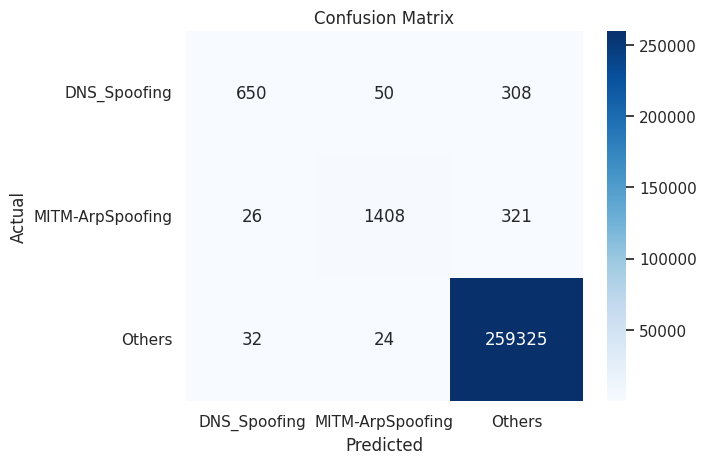

In [12]:
# Отчёт классификации
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))

# Матрица ошибок
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## SHAP-объекты и объяснение модели

##### 0. Уменьшение выборки примеров классов для более быстрого создания массива shap_values

shap_values (значения SHAP) — массив, в котором каждый элемент показывает:  

- какой вклад внёс признак в итоговое предсказание

- положительное значение — признак увеличивает предсказание

- отрицательное значение — уменьшает

In [13]:
dns_code, arp_code = le.transform(['DNS_Spoofing', 'MITM-ArpSpoofing'])

idx_dns_all = np.where(y_test == dns_code)[0]
idx_arp_all = np.where(y_test == arp_code)[0]
idx_oth_all = np.where((y_test != dns_code) & (y_test != arp_code))[0]

target_dns = 600
target_arp = 600
target_oth = 3000

if len(idx_dns_all) >= target_dns:
    idx_dns = np.random.choice(idx_dns_all, size=target_dns, replace=False)
else:
    idx_dns = np.random.choice(idx_dns_all, size=target_dns, replace=True)

if len(idx_arp_all) >= target_arp:
    idx_arp = np.random.choice(idx_arp_all, size=target_arp, replace=False)
else:
    idx_arp = np.random.choice(idx_arp_all, size=target_arp, replace=True)

# для «Others» — случайно без возвращения
idx_oth = np.random.choice(idx_oth_all, size=target_oth, replace=False)

# объединяем и перемешиваем
idx_new = np.concatenate([idx_dns, idx_arp, idx_oth])
np.random.shuffle(idx_new)

# строим новый X_small и y_small
X_small = X_test[idx_new]
y_small = y_test.iloc[idx_new]

print("X_small:")
print(" DNS_Spoofing:", np.sum(y_small == dns_code))
print(" MITM-ArpSpoofing:", np.sum(y_small == arp_code))
print(" Others:",         np.sum((y_small != dns_code) & (y_small != arp_code)))

X_small:
 DNS_Spoofing: 600
 MITM-ArpSpoofing: 600
 Others: 3000


In [14]:
# RandomForest — это tree-based модель, поэтому используется TreeExplainer
explainer = shap.TreeExplainer(clf, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_small)

 ##### 1. Выявление важных признаков

In [20]:
# функция, позволяющая строить график SHAP-значений
def shap_research(
    shap_values,
    X_small,
    explainer=explainer,
    feature_names=df_feature_names,
    class_index: int = 0,
    class_names: list = ['DNS_Spoofing', 'MITM-ArpSpoofing', 'Others'],
    top_n: int = 30,
    show_waterfall: bool = False,
    sample_index: int = 0
):

    # Получаем массив shap-значений для нужного класса
    if isinstance(shap_values, list):
        sv = shap_values[class_index]
    else:
        sv = shap_values
    if sv.ndim == 3:
        sv = sv[:, :, class_index]

    # Вычисляем среднее абсолютное значение SHAP
    mean_abs = np.abs(sv).mean(axis=0)

    # Определяем имена признаков
    if isinstance(X_small, pd.DataFrame):
        names = X_small.columns.tolist()
    else:
        if feature_names is None:
            raise ValueError("Для ndarray X_small нужно передать feature_names")
        names = feature_names

    # Собираем DataFrame с важностями
    df_imp = pd.DataFrame({
        'Feature': names,
        'MeanAbsSHAP': mean_abs
    }).sort_values('MeanAbsSHAP', ascending=False)

    # Строим bar-plot top_n
    top_feats = df_imp.head(top_n)
    plt.figure(figsize=(8, max(4, 0.25*top_n)))
    plt.barh(top_feats['Feature'][::-1], top_feats['MeanAbsSHAP'][::-1])
    plt.xlabel('Среднее |SHAP|')
    plt.title(f'Важность признаков для класса "{class_names[class_index]}" (top {top_n})')
    plt.tight_layout ()
    plt.show()

    # Опциональный waterfall для одного примера
    if show_waterfall:
        print(f'\nWaterfall для класса "{class_names[class_index]}", пример под номером={sample_index}')
        base_val = explainer.expected_value[class_index]

        expl = shap.Explanation(
            values=sv[sample_index],
            base_values=base_val,
            data=(X_small.iloc[sample_index].values if isinstance(X_small, pd.DataFrame)
                  else X_small[sample_index]),
            feature_names=names
        )
        shap.plots.waterfall(expl, max_display=top_n)
        #shap.initjs()
        # shap.force_plot(
        #     expl.base_values,
        #     expl.values,
        #     expl.data,
        #     feature_names=expl.feature_names,
        #     matplotlib=False
        # )
    return df_imp


##### 1.1 Для DNS_Spoofing

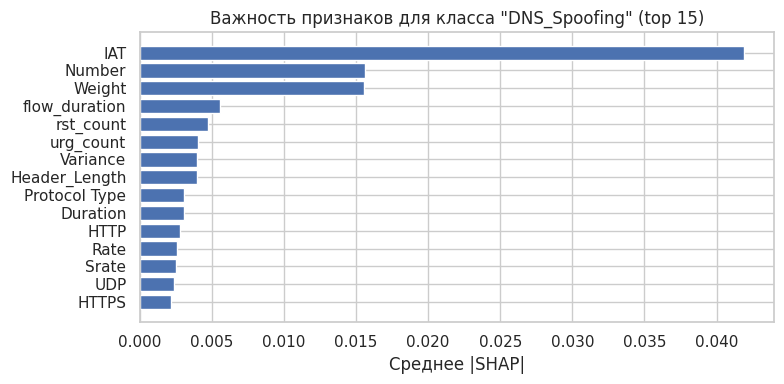


Waterfall для класса "DNS_Spoofing", пример под номером=5


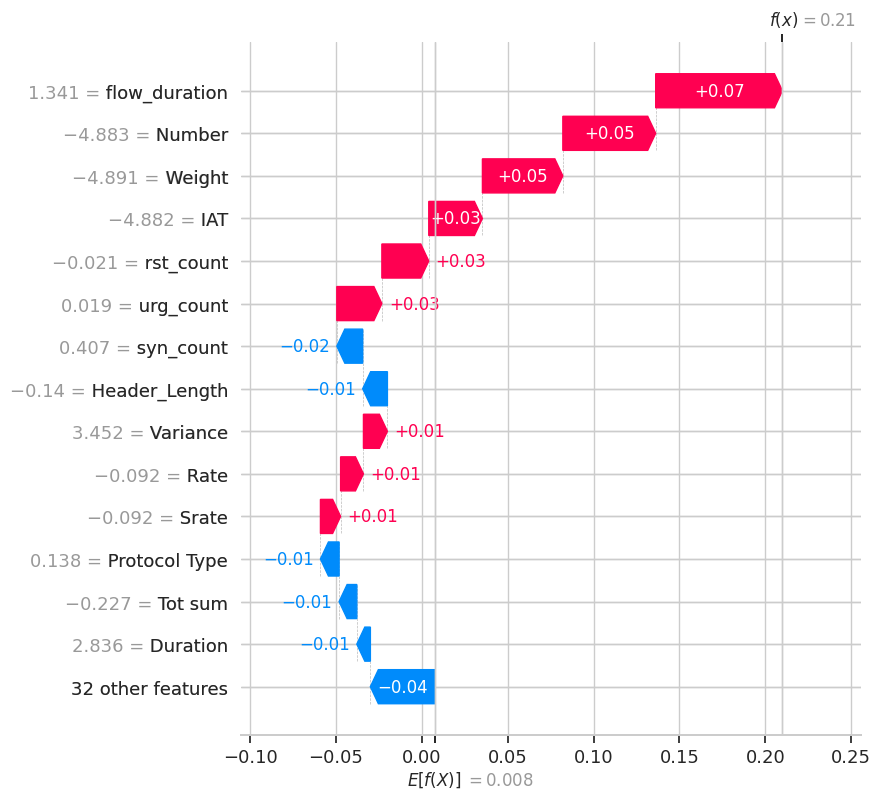

In [28]:
imp_df = shap_research(shap_values, X_small, class_index=0, top_n=15, show_waterfall=True, sample_index=5)

##### 1.2 Для MITM-ArpSpoofing

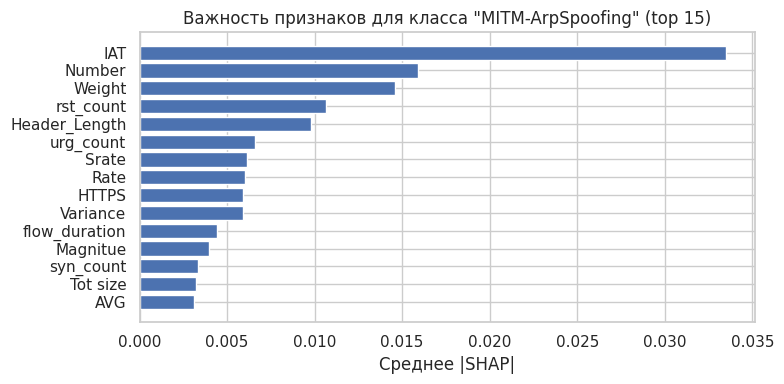


Waterfall для класса "MITM-ArpSpoofing", пример под номером=5


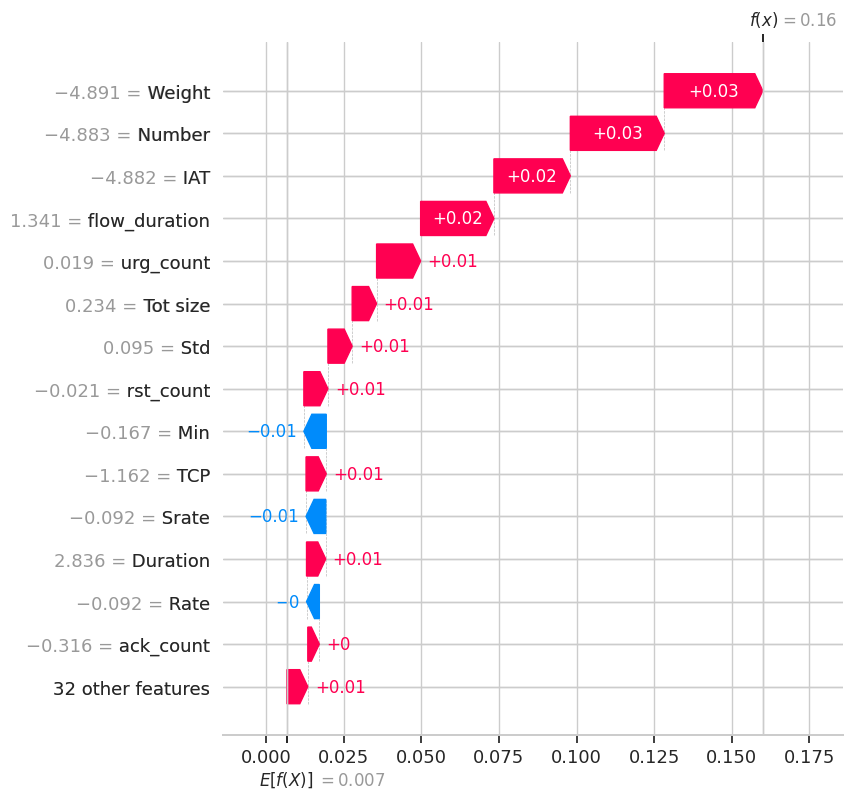

In [22]:
imp_df = shap_research(shap_values, X_small, class_index=1, top_n=15, show_waterfall=True, sample_index=5)

## Изменение признаков и построение состязательной атаки

**Задача:** спользуя summary_plot SHAP для классов DNS_Spoofing и MITM-ArpSpoofing, определить, какие признаки нужно изменить, чтобы минимальными изменениями "обмануть" модель, и проверить это экспериментально — сгенерировать такие записи и оценить их классификацию

In [29]:
others_code = le.transform(['Others'])[0]  
oth_idx = np.where(y_test == others_code)[0]

print(f'Others samples:  {len(oth_idx)}')

Others samples:  259381


In [33]:
# Индексы классов
idx_dns_all = np.where(y_test == dns_code)[0]
idx_arp_all = np.where(y_test == arp_code)[0]

X_test_df = pd.DataFrame(X_test, columns=df_feature_names)

# Копии для атаки
adv_dns_df  = X_test_df.iloc[idx_dns_all].copy()
adv_mitm_df = X_test_df.iloc[idx_arp_all].copy()

In [34]:
def adaptive_attack(df, model, true_label, target_label, feature_list, step=0.05, max_iter=20):
    df_adv = df.copy()
    for i in range(len(df)):
        sample = df_adv.iloc[i].copy()
        original = sample.copy()
        for iteration in range(max_iter):
            pred = model.predict([sample])[0]
            if pred == target_label:
                # Успешно обманули модель
                break
            # Слегка изменим признаки в направлении others (уменьшим значения)
            sample[feature_list] -= step * np.abs(original[feature_list])
        df_adv.iloc[i] = sample
    return df_adv

In [35]:
# Список признаков, которые надо менять
attack_features_dns  = ['IAT', 'Number', 'Weight', 'flow_duration']
attack_features_mitm = ['IAT', 'Number', 'Weight', 'flow_duration']

# Применяем атаку:
adv_dns_df = adaptive_attack(adv_dns_df, clf, dns_code, others_code, attack_features_dns)
adv_mitm_df = adaptive_attack(adv_mitm_df, clf, arp_code, others_code, attack_features_mitm)

# Вставляем обратно
X_test_adv = X_test.copy()
X_test_adv[idx_dns_all, :]  = adv_dns_df.values
X_test_adv[idx_arp_all, :] = adv_mitm_df.values


=== BEFORE attack ===
                  precision    recall  f1-score   support

    DNS_Spoofing       0.92      0.64      0.76      1008
MITM-ArpSpoofing       0.95      0.80      0.87      1755
          Others       1.00      1.00      1.00    259381

        accuracy                           1.00    262144
       macro avg       0.96      0.82      0.88    262144
    weighted avg       1.00      1.00      1.00    262144


=== AFTER adaptive attack ===
                  precision    recall  f1-score   support

    DNS_Spoofing       0.65      0.10      0.18      1008
MITM-ArpSpoofing       0.89      0.31      0.46      1755
          Others       0.99      1.00      1.00    259381

        accuracy                           0.99    262144
       macro avg       0.84      0.47      0.54    262144
    weighted avg       0.99      0.99      0.99    262144


Confusion matrix AFTER attack:


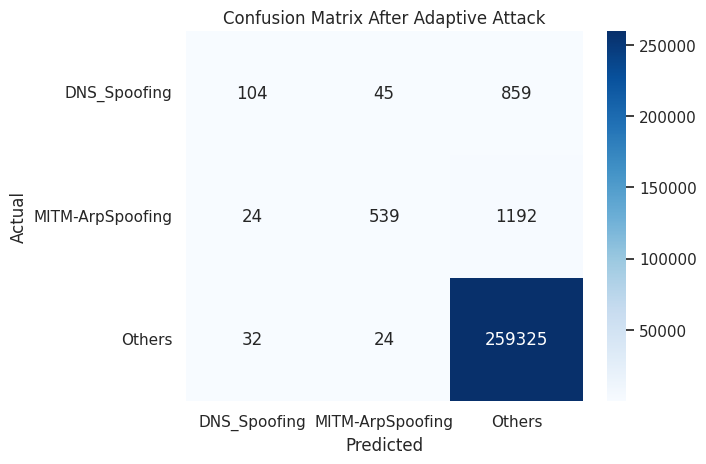

In [36]:
y_pred_orig = clf.predict(X_test)
y_pred_adv  = clf.predict(X_test_adv)

print("\n=== BEFORE attack ===")
print(classification_report(y_test, y_pred_orig, target_names=le.classes_, zero_division=0))

print("\n=== AFTER adaptive attack ===")
print(classification_report(y_test, y_pred_adv, target_names=le.classes_, zero_division=0))

# Confusion Matrix после атаки
print("\nConfusion matrix AFTER attack:")
conf_matrix = confusion_matrix(y_test, y_pred_adv)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix After Adaptive Attack")
plt.show()

Из 1008 «шумовых» DNS-потоков 859 ушли в Others; из 1755 MITM-потоков 1192 ушли в Others.


Используя SHAP значения для классов DNS_Spoofing и MITM-ArpSpoofing, были выявлены ключевые признаки, наиболее сильно влияющие на решение модели:
**IAT**, Number, Weight, flow_duration, rst_count, urg_count

Для генерации состязательных примеров значения этих признаков были минимально изменены так, чтобы сохранить минимальное отличие от реальных данных, но снизить вклад этих признаков в решение модели.

#### Обоснование

| Признак                            | Что «видит» модель                                                                                                            | Как атакующий может легально изменить                                 |
| :--------------------------------: | :---------------------------------------------------------------------------------------------------------------------------: | :-------------------------------------------------------------------: |
| **IAT** (Inter-Arrival Time)       | При DNS-spoof потоки приходят «рывками»: много пакетов с маленькими паузами → низкий IAT повышает SHAP-вклад в метку «атака». | Сделать небольшие задержки (throttling, random jitter).               |
| **Number** (число пакетов во flow) | Спуфинг генерирует всплеск служебных пакетов.                                                                                 | Разбить атаку на несколько коротких сессий или вставить dummy-пакеты. |
| **Weight** (байт во flow)          | Большой, потому что идут полные DNS-ответы.                                                                                   | Сжать полезную нагрузку, убрать лишние секции.                        |
| **rst\_count / urg\_count**        | В атаках часто ставят RST/URG, чтобы «обрубить» соединения или замаскировать спуф.                                            | Просто не ставить флаги, либо ограничить их.                          |

### Выводы

1. Используя SHAP значения для классов DNS_Spoofing и MITM-ArpSpoofing, были выявлены ключевые признаки, наиболее сильно влияющие на решение модели:
**IAT**, Number, Weight, flow_duration, rst_count, urg_count

2.  Для генерации состязательных примеров значения этих признаков были минимально изменены так, чтобы сохранить минимальное отличие от реальных данных, но снизить вклад этих признаков в решение модели. Результаты атаки были успешными:

   - Большая часть DNS и MITM-пакетов осталась необнаруженной.

   - recall снизился до критических значений (10% для DNS и 31% для MITM).

3. Классификатор оказался уязвим:

    - Простые изменения в признаках (без изменения класса трафика) могут обмануть модель.

    - Это может быть использовано злоумышленником для обхода системы обнаружения.